In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:11<00:00, 897kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.44MB/s]


In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h1 = F.relu(self.bn1(self.fc1(x)))
        h1 = self.dropout(h1)
        h2 = F.relu(self.bn2(self.fc2(h1)))
        h2 = self.dropout(h2)
        mu = self.fc_mu(h2)
        logvar = torch.clamp(self.fc_logvar(h2), min=-20, max=20)
        return mu, logvar


In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim // 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, z):
        h1 = F.relu(self.bn1(self.fc1(z)))
        h1 = self.dropout(h1)
        h2 = F.relu(self.bn2(self.fc2(h1)))
        h2 = self.dropout(h2)
        x_hat = torch.sigmoid(self.fc3(h2))
        x_hat = torch.clamp(x_hat, min=1e-7, max=1-1e-7)
        return x_hat


In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar


In [5]:
def vae_loss(x_hat, x, mu, logvar, beta=1.0):
    x_hat = torch.clamp(x_hat, min=1e-7, max=1-1e-7)
    x = torch.clamp(x, min=0, max=1)

    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')

    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    if torch.isnan(recon_loss) or torch.isnan(kld_loss):
        print("NaN detected in loss!")
        return torch.tensor(0.0, device=x.device), recon_loss, kld_loss

    return recon_loss + beta * kld_loss, recon_loss, kld_loss


In [6]:
input_dim = 28 * 28
hidden_dim = 512
latent_dim = 20
learning_rate = 1e-3
num_epochs = 50

vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_losses = []
test_losses = []
recon_losses = []
kld_losses = []

def train_epoch(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    recon_loss_epoch = 0
    kld_loss_epoch = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)
        data = torch.clamp(data, min=0, max=1)

        optimizer.zero_grad()

        x_hat, mu, logvar = model(data)
        loss, recon_loss, kld_loss = vae_loss(x_hat, data, mu, logvar)

        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch}, batch {batch_idx}")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        recon_loss_epoch += recon_loss.item()
        kld_loss_epoch += kld_loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_epoch / len(train_loader.dataset)
    avg_kld = kld_loss_epoch / len(train_loader.dataset)

    return avg_loss, avg_recon, avg_kld

def test_epoch(model, test_loader):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, input_dim).to(device)
            data = torch.clamp(data, min=0, max=1)
            x_hat, mu, logvar = model(data)
            loss, _, _ = vae_loss(x_hat, data, mu, logvar)
            if not torch.isnan(loss):
                test_loss += loss.item()

    return test_loss / len(test_loader.dataset)

for epoch in range(num_epochs):
    train_loss, recon_loss, kld_loss = train_epoch(vae, train_loader, optimizer, epoch)
    test_loss = test_epoch(vae, test_loader)

    scheduler.step(test_loss)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    recon_losses.append(recon_loss)
    kld_losses.append(kld_loss)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 0, Batch 0, Loss: 72117.4844
Epoch 0, Batch 100, Loss: 19862.1660
Epoch 0, Batch 200, Loss: 18270.2227
Epoch 0, Batch 300, Loss: 18651.1230
Epoch 0, Batch 400, Loss: 16828.4004
Epoch 0: Train Loss: 151.8912, Test Loss: 116.2608
Epoch 1, Batch 0, Loss: 16703.7773
Epoch 1, Batch 100, Loss: 16639.2129
Epoch 1, Batch 200, Loss: 16920.5801
Epoch 1, Batch 300, Loss: 16562.0000
Epoch 1, Batch 400, Loss: 16342.3750
Epoch 1: Train Loss: 129.6755, Test Loss: 109.5947
Epoch 2, Batch 0, Loss: 15908.9238
Epoch 2, Batch 100, Loss: 16031.5830
Epoch 2, Batch 200, Loss: 15776.1748
Epoch 2, Batch 300, Loss: 15542.7275
Epoch 2, Batch 400, Loss: 15599.8623
Epoch 2: Train Loss: 125.9468, Test Loss: 106.7315
Epoch 3, Batch 0, Loss: 16333.1113
Epoch 3, Batch 100, Loss: 15744.7773
Epoch 3, Batch 200, Loss: 16434.7129
Epoch 3, Batch 300, Loss: 15798.6865
Epoch 3, Batch 400, Loss: 15969.2275
Epoch 3: Train Loss: 124.0961, Test Loss: 105.2352
Epoch 4, Batch 0, Loss: 15816.1387
Epoch 4, Batch 100, Loss: 161

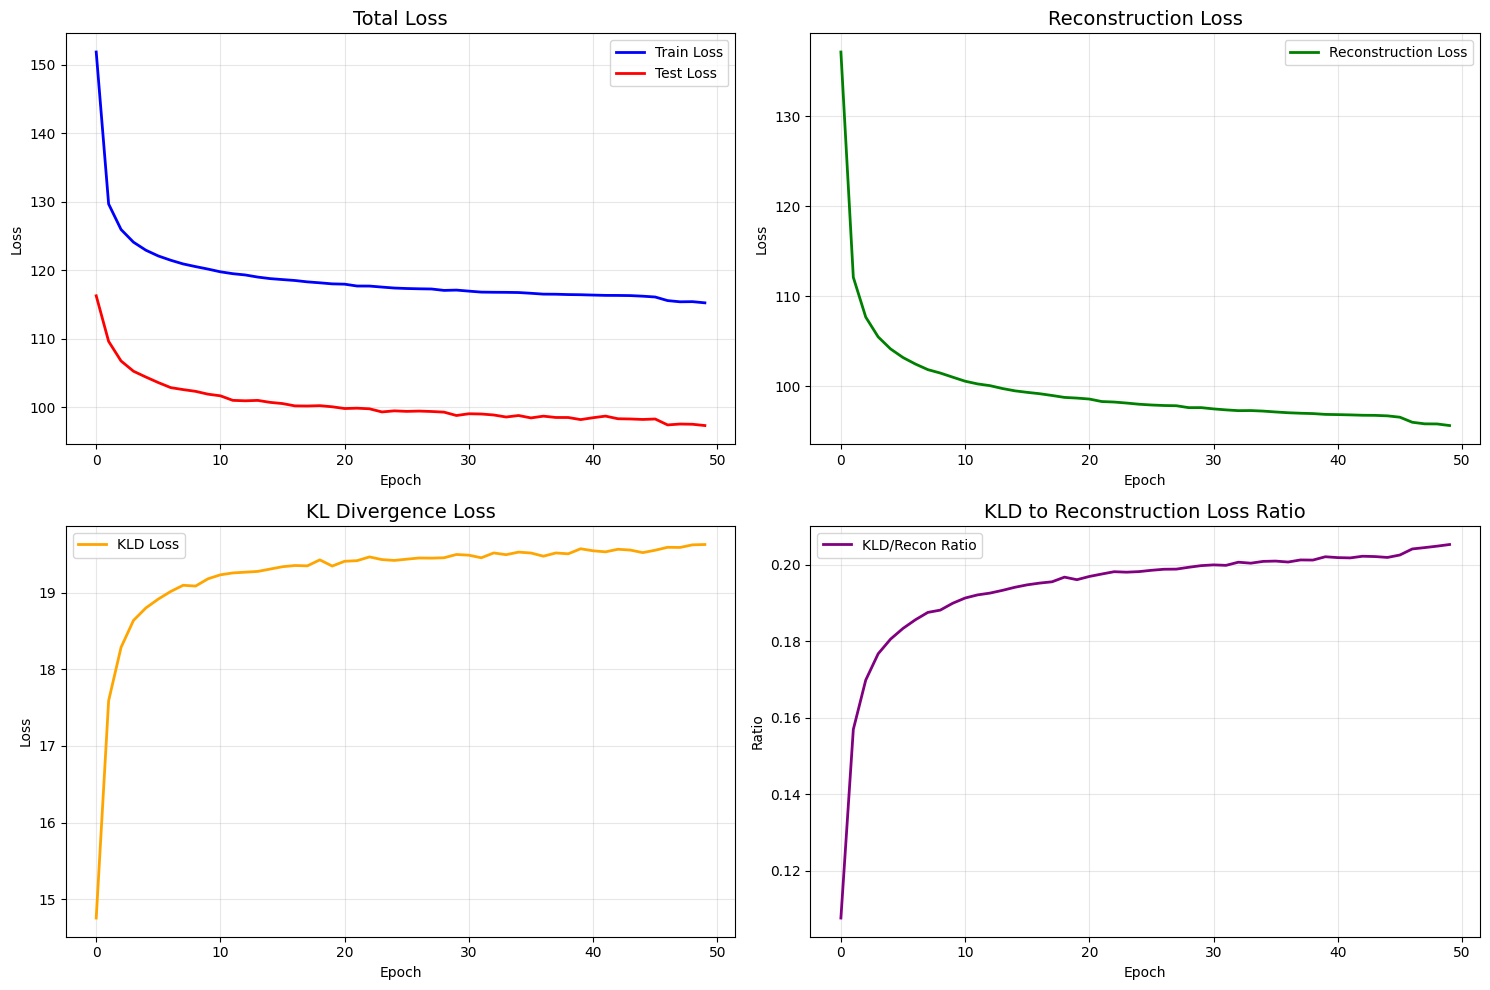

In [8]:
def plot_training_curves():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].plot(train_losses, label='Train Loss', color='blue', linewidth=2)
    axes[0, 0].plot(test_losses, label='Test Loss', color='red', linewidth=2)
    axes[0, 0].set_title('Total Loss', fontsize=14)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(recon_losses, label='Reconstruction Loss', color='green', linewidth=2)
    axes[0, 1].set_title('Reconstruction Loss', fontsize=14)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].plot(kld_losses, label='KLD Loss', color='orange', linewidth=2)
    axes[1, 0].set_title('KL Divergence Loss', fontsize=14)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    loss_ratio = np.array(kld_losses) / (np.array(recon_losses) + 1e-8)
    axes[1, 1].plot(loss_ratio, label='KLD/Recon Ratio', color='purple', linewidth=2)
    axes[1, 1].set_title('KLD to Reconstruction Loss Ratio', fontsize=14)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Ratio')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_reconstructions(model, test_loader, num_samples=10):
    model.eval()
    with torch.no_grad():
        data, labels = next(iter(test_loader))
        data = data[:num_samples].to(device)
        data_flat = data.view(-1, input_dim)
        data_flat = torch.clamp(data_flat, min=0, max=1)

        x_hat, mu, logvar = model(data_flat)

        data = data.cpu()
        x_hat = x_hat.view(-1, 28, 28).cpu()

        fig, axes = plt.subplots(4, num_samples, figsize=(num_samples * 2, 8))

        for i in range(num_samples):
            axes[0, i].imshow(data[i].squeeze(), cmap='gray', vmin=0, vmax=1)
            axes[0, i].set_title(f'Original ({labels[i].item()})')
            axes[0, i].axis('off')

            axes[1, i].imshow(x_hat[i], cmap='gray', vmin=0, vmax=1)
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')

            diff = torch.abs(data[i].squeeze() - x_hat[i])
            axes[2, i].imshow(diff, cmap='hot', vmin=0, vmax=1)
            axes[2, i].set_title('Difference')
            axes[2, i].axis('off')

            reconstruction_error = torch.mean(diff).item()
            axes[3, i].bar(['Error'], [reconstruction_error], color='red', alpha=0.7)
            axes[3, i].set_title(f'MSE: {reconstruction_error:.3f}')
            axes[3, i].set_ylim(0, 0.5)

        plt.tight_layout()
        plt.show()

def generate_samples_grid(model, num_samples=25):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated = model.decoder(z)
        generated = generated.view(-1, 28, 28).cpu()

        fig, axes = plt.subplots(5, 5, figsize=(12, 12))
        for i in range(num_samples):
            row, col = i // 5, i % 5
            axes[row, col].imshow(generated[i], cmap='gray', vmin=0, vmax=1)
            axes[row, col].axis('off')

        plt.suptitle('Generated Samples from Random Latent Vectors', fontsize=16)
        plt.tight_layout()
        plt.show()

def analyze_latent_space_statistics(model, test_loader):
    model.eval()
    all_mu = []
    all_logvar = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.view(-1, input_dim).to(device)
            data = torch.clamp(data, min=0, max=1)
            mu, logvar = model.encoder(data)
            all_mu.append(mu.cpu())
            all_logvar.append(logvar.cpu())
            all_labels.append(labels)

    all_mu = torch.cat(all_mu, dim=0)
    all_logvar = torch.cat(all_logvar, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    axes[0, 0].hist(all_mu.mean(dim=0).numpy(), bins=50, alpha=0.7, color='blue')
    axes[0, 0].set_title('Distribution of Mean μ across latent dimensions')
    axes[0, 0].set_xlabel('μ value')
    axes[0, 0].set_ylabel('Frequency')

    axes[0, 1].hist(all_logvar.mean(dim=0).numpy(), bins=50, alpha=0.7, color='red')
    axes[0, 1].set_title('Distribution of log(σ²) across latent dimensions')
    axes[0, 1].set_xlabel('log(σ²) value')
    axes[0, 1].set_ylabel('Frequency')

    mu_std_per_dim = all_mu.std(dim=0)
    axes[0, 2].plot(mu_std_per_dim.numpy(), 'o-', color='green')
    axes[0, 2].set_title('Standard deviation of μ per latent dimension')
    axes[0, 2].set_xlabel('Latent dimension')
    axes[0, 2].set_ylabel('Std(μ)')

    logvar_mean_per_digit = []
    for digit in range(10):
        mask = all_labels == digit
        if mask.sum() > 0:
            logvar_mean_per_digit.append(all_logvar[mask].mean().item())
        else:
            logvar_mean_per_digit.append(0)

    axes[1, 0].bar(range(10), logvar_mean_per_digit, color='orange', alpha=0.7)
    axes[1, 0].set_title('Average log(σ²) per digit class')
    axes[1, 0].set_xlabel('Digit')
    axes[1, 0].set_ylabel('Average log(σ²)')

    mu_norm = torch.norm(all_mu, dim=1)
    axes[1, 1].hist(mu_norm.numpy(), bins=50, alpha=0.7, color='purple')
    axes[1, 1].set_title('Distribution of ||μ|| (L2 norm)')
    axes[1, 1].set_xlabel('||μ||')
    axes[1, 1].set_ylabel('Frequency')

    kl_divergence = -0.5 * torch.sum(1 + all_logvar - all_mu.pow(2) - all_logvar.exp(), dim=1)
    axes[1, 2].hist(kl_divergence.numpy(), bins=50, alpha=0.7, color='brown')
    axes[1, 2].set_title('Distribution of KL divergence per sample')
    axes[1, 2].set_xlabel('KL divergence')
    axes[1, 2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_training_curves()

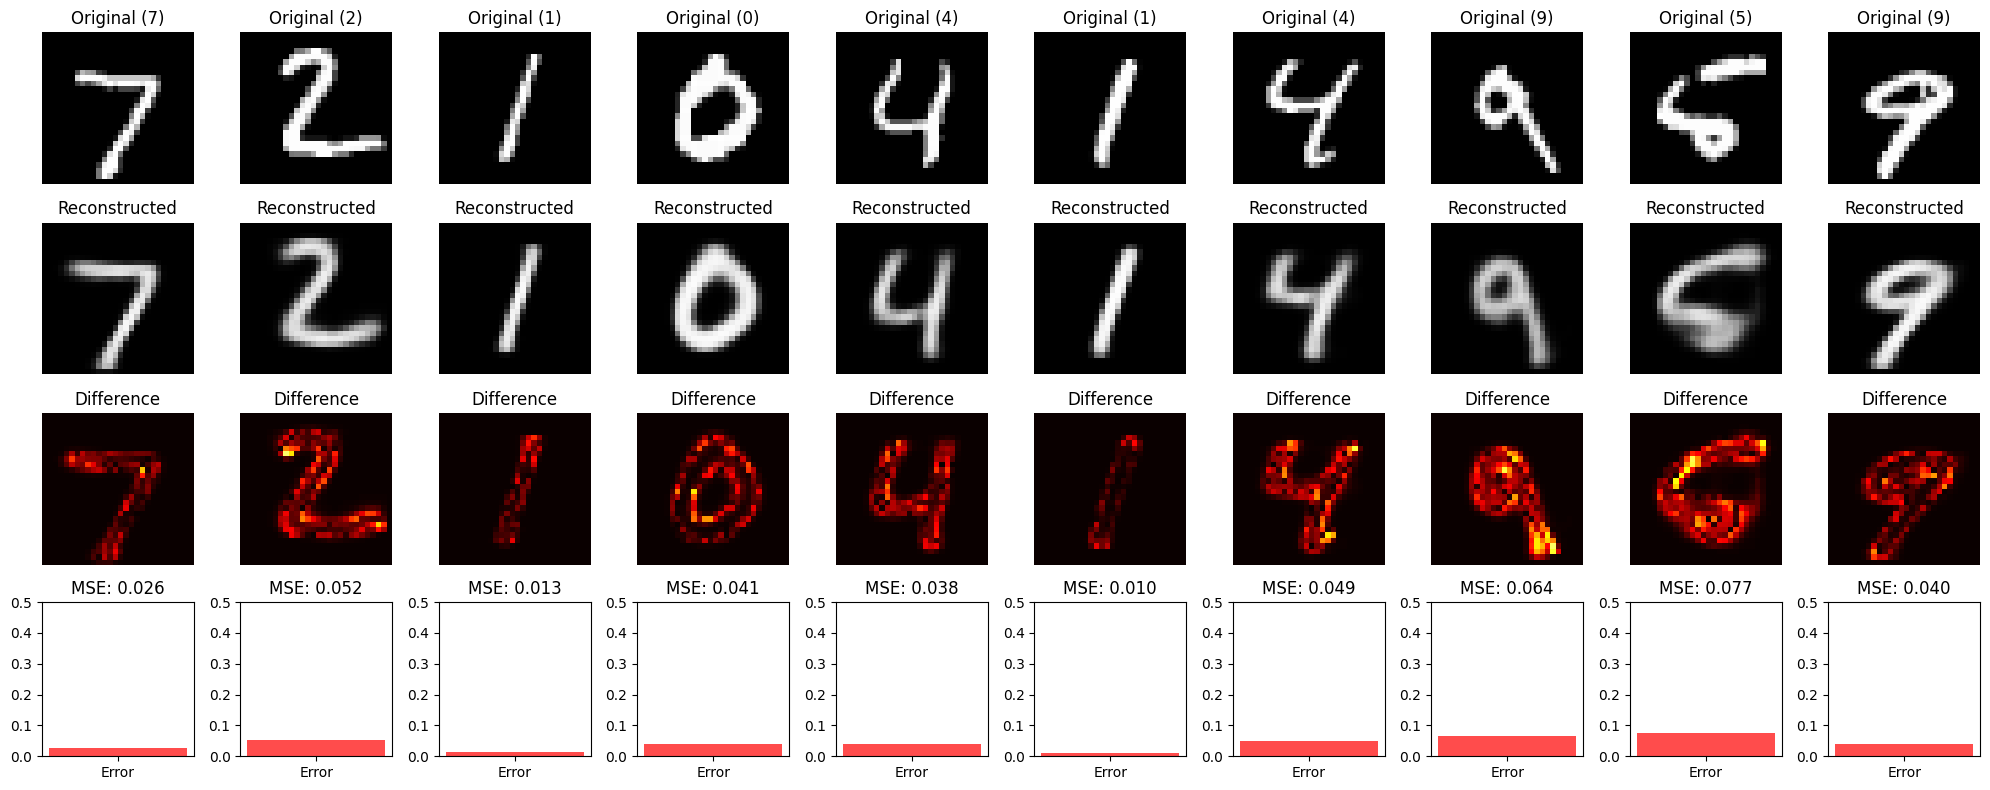

In [9]:
visualize_reconstructions(vae, test_loader, num_samples=10)

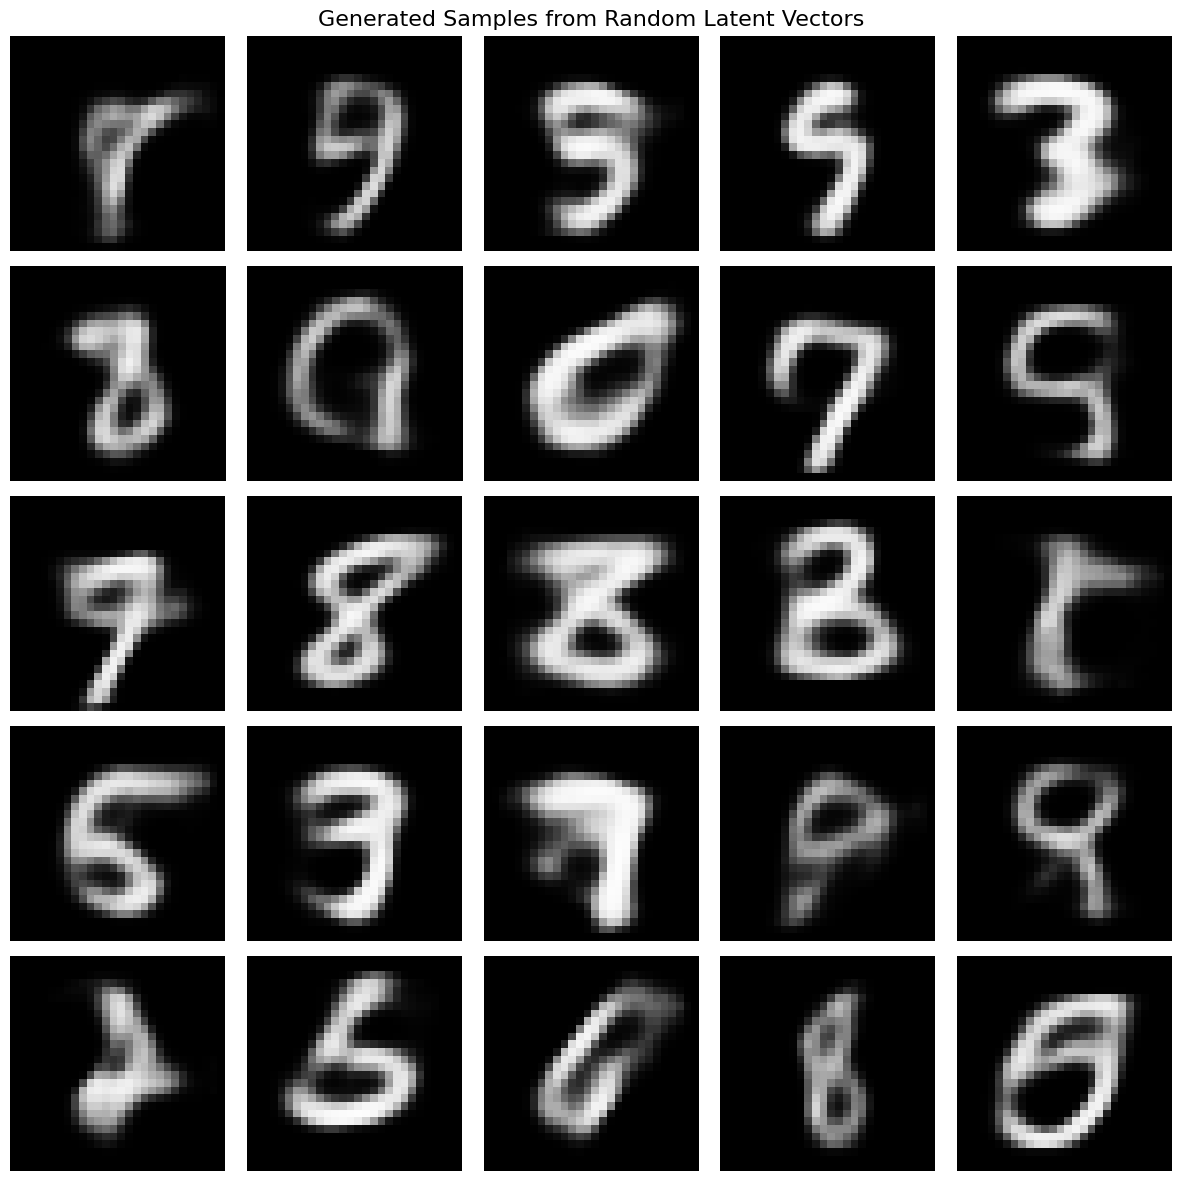

In [10]:
generate_samples_grid(vae, num_samples=25)

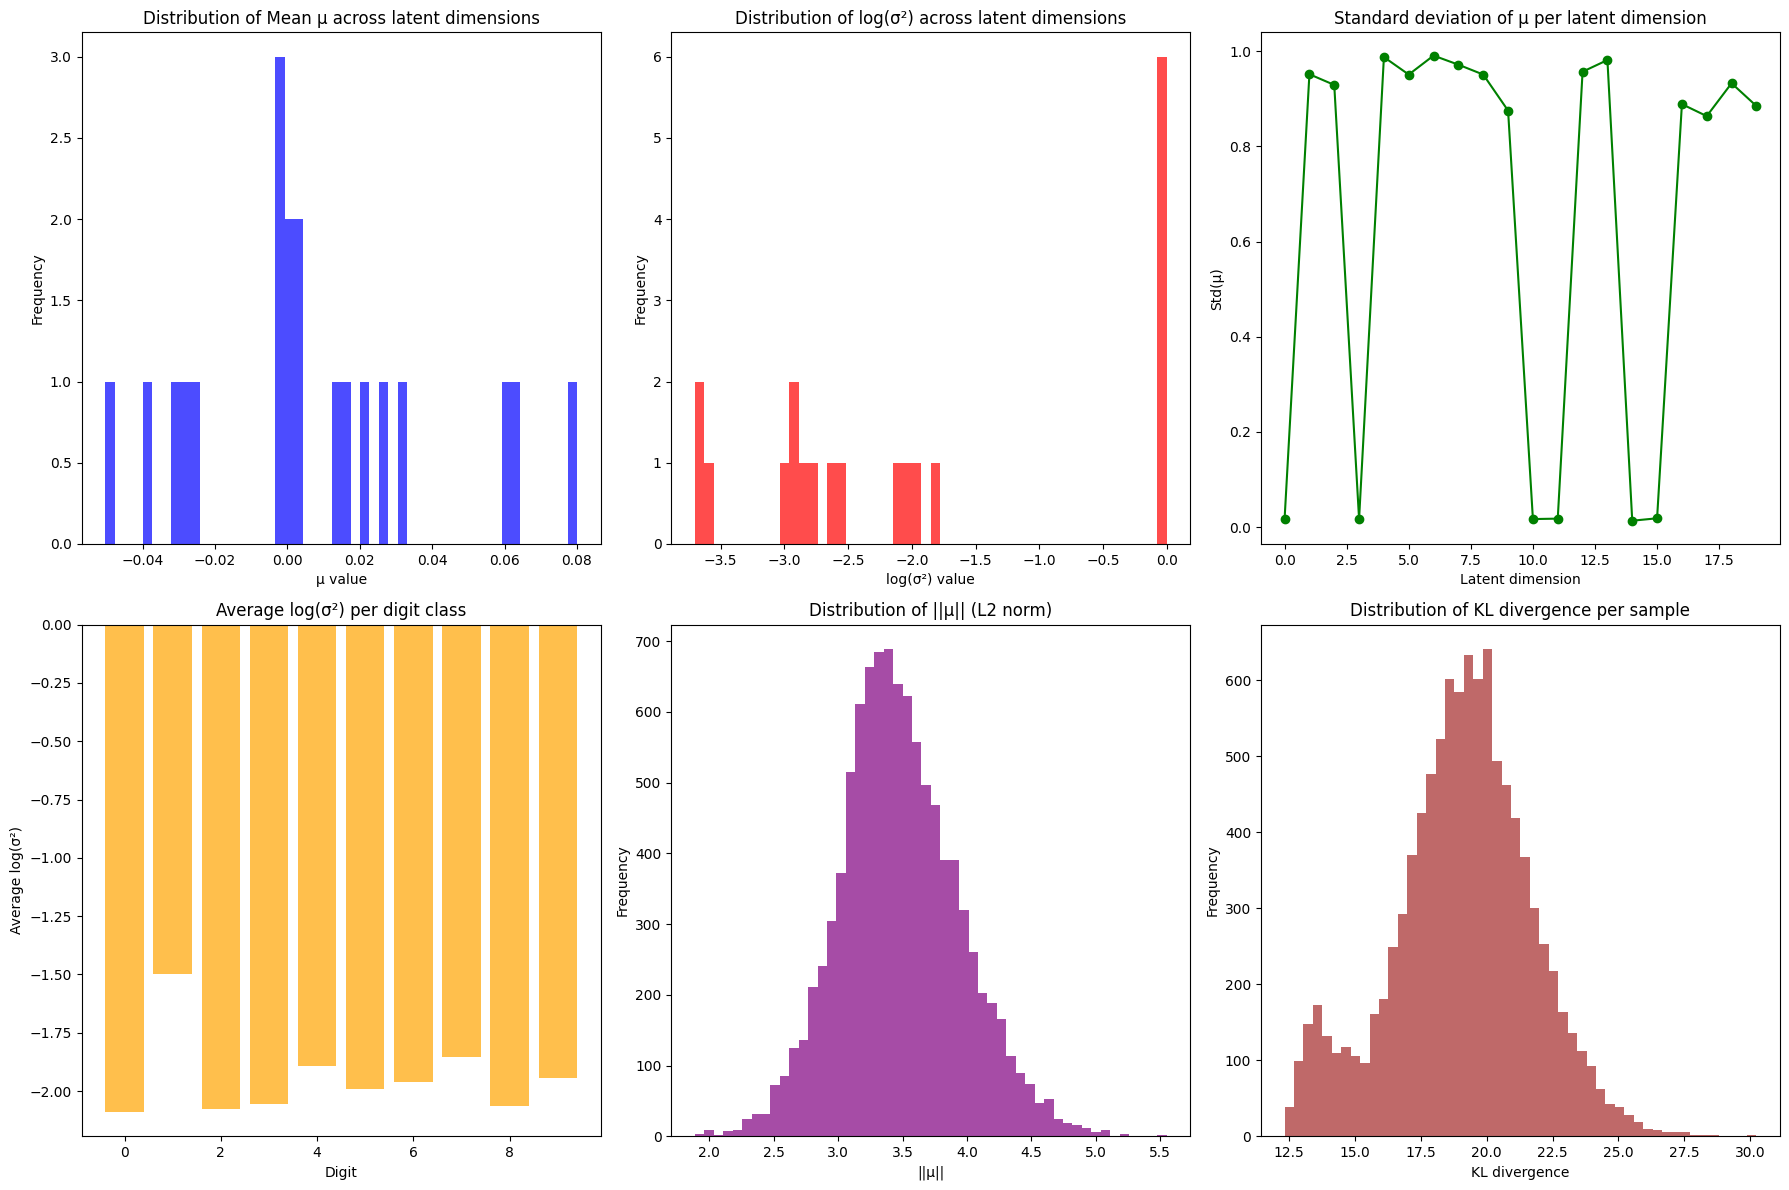

In [11]:
analyze_latent_space_statistics(vae, test_loader)